In [1]:
!pip install datasets -q
!pip install peft -q
!pip install accelerate -q
!pip install transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
t

In [2]:
import re
import time
import gc
import ctypes
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from peft import (
    get_peft_config, 
    get_peft_model, 
    LoraConfig,
    TaskType,
)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.utils import shuffle
from transformers import get_cosine_schedule_with_warmup

2025-07-24 15:03:49.169239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753369429.343846      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753369429.398455      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reward Functions

This is accuracy reward which is rewarded for correct output.

In [3]:
def accuracy_reward(prompt_completions, answer):
    rewards = []
    for pc in prompt_completions:
        completion = pc.split('<answer>')[-1]
        if answer in completion and (pc.count('<answer>') == 2):
            rewards.append(2.0)
        else:
            rewards.append(0.0)
    return rewards

This rewards for maintaining the format.

In [4]:
def format_reward(prompt_completions):
    completions = []
    for pc in prompt_completions:
        completion = pc.split('\nAssistant:')[-1]
        count_eos_string = completion.count(tokenizer.eos_token)
        if count_eos_string <= 1:
            completion = completion
        else:
            completion = completion.replace(tokenizer.eos_token, '')
            completion = completion + tokenizer.eos_token
        completions.append(completion)
    rewards = []
    pattern = re.compile(r".*<reasoning>\n.+?\n</reasoning>\n<answer>\n.+?\n</answer><\|endoftext\|>$", re.DOTALL)
    for completion in completions:
        rewards.append(0.5 if pattern.fullmatch(completion) else 0.0)
    return rewards

## Load and Process Data

In [5]:
import datasets

data = datasets.load_dataset('openai/gsm8k', 'main')

df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

### Extract Answer

In [6]:
df_train['answer'] = df_train['answer'].str.split('####').str[-1].str.strip()
df_test['answer'] = df_test['answer'].str.split('####').str[-1].str.strip()

## Create and Apply Chat Template

In [7]:
SYSTEM = """Assistant, please respond to the user in the following format:

<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
"""

In [8]:
df_train['prompt'] = SYSTEM + 'User: ' + df_train['question'].str.strip() + '\nAssistant:'
df_test['prompt'] = SYSTEM + 'User: ' + df_test['question'].str.strip() + '\nAssistant:'

In [9]:
print(df_train.prompt[69])

Assistant, please respond to the user in the following format:

<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
User: Carly collected 7 starfish with 5 arms each and one seastar with 14 arms. How many arms do the animals she collected have in total?
Assistant:


In [10]:
model_path = 'HuggingFaceTB/SmolLM2-360M' 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [12]:
peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        target_modules='all-linear',
        bias='none',
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.0
    )

model = get_peft_model(model, peft_config)


In [13]:
ref_model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map=device,
    torch_dtype=torch.bfloat16
).eval().requires_grad_(False)

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

## Completion Generation Function

In [15]:
def generate_completions(model, tokenizer, prompts, temperature=0.9, num_completions=2, max_completion_length=50):
    
    model.eval() 
    
    completions = []
    for prompt in tqdm(prompts):

        encodings = tokenizer(prompt, return_tensors='pt').to(model.device)
        
        # Generate completions using the current policy
        with torch.inference_mode():
            outs = model.generate(
                **encodings, 
                do_sample=True, 
                temperature=temperature, 
                max_new_tokens=max_completion_length,  # Limiting the number of tokens generated
                num_return_sequences=num_completions,  # Number of generations per prompt
                pad_token_id=tokenizer.eos_token_id
            )
        
        decoded_texts = tokenizer.batch_decode(outs, skip_special_tokens=False)
        completions.extend(decoded_texts)
        
    model.train()
    
    return completions

## Get Log Probs Function

In [16]:
def get_log_probs(model, prompt, prompt_completions, type):
    
    if type == 'new':
        prompt_ids = tokenizer(prompt)
        prompt_len = len(prompt_ids)
        encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)

        with autocast(dtype=torch.bfloat16, device_type='cuda'):
            logits = model(**encodings).logits

    else:
        with torch.no_grad():
            prompt_ids = tokenizer(prompt)
            prompt_len = len(prompt_ids)
            encodings = tokenizer(prompt_completions, return_tensors='pt', padding='longest').to(model.device)
    
            with autocast(dtype=torch.bfloat16, device_type='cuda'):
                logits = model(**encodings).logits
        
    start = len(tokenizer(prompt).input_ids) 

    all_log_probs = []
    for l, input_ids in zip(logits, encodings.input_ids):
        eos_pos = torch.where(input_ids == tokenizer.eos_token_id)[0]

        if eos_pos.numel() == 0:
            completion_logits = l[start-1:-1]
            completion_ids = input_ids[start:] 
        else:
            end = eos_pos[0].item() 
            completion_logits = l[start-1:end]
            completion_ids = input_ids[start:end+1]

        probs = F.softmax(completion_logits, dim=-1)
        log_probs = torch.log(probs)
        log_probs = torch.gather(log_probs, 1, completion_ids.unsqueeze(1)).squeeze(1)
        all_log_probs.append(log_probs)

    return all_log_probs

In [17]:
def check(t):
    print('ISNAN', torch.isnan(t).any())
    print('ISINF', torch.isinf(t).any())

## Hyperparameters

In [18]:
epochs = 1
n_iterations = 5
learning_rate = 3e-5
weight_decay = 0.005
warmups = 200

eps = 0.2
beta = 0.005

## Training 

In [19]:
def clean_memory(deep=True):
    gc.collect()
    if deep:
        ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [20]:
prompts, answers = shuffle(df_train.prompt, df_train.answer)

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, 
                                            num_training_steps=epochs*len(prompts)*n_iterations,
                                            num_warmup_steps=warmups)

scaler = GradScaler()

In [22]:
start_time = time.time()
max_duration = 5 * 60 * 60  


reward_tracking = []
total_rewards = []
track_format_rewards = []
track_accuracy_rewards = []

step = 0
for epoch in range(epochs):
    for idx in range(len(df_train)):
        step += 1

        if time.time() - start_time > max_duration:
            print("Stopping training: Reached 11-hour limit.")
            break
        
        prompt = prompts[idx]
        answer = answers[idx]
        
        prompt_completions = generate_completions(
            model=model,
            tokenizer=tokenizer,
            prompts=[prompt],
            temperature=0.8, 
            num_completions=5,
            max_completion_length=512)

        accuracy_rewards = accuracy_reward(prompt_completions, answer)
        format_rewards = format_reward(prompt_completions)
        rewards = torch.tensor(accuracy_rewards) + torch.tensor(format_rewards)
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-4)

        old_log_probs = get_log_probs(model, prompt, prompt_completions, type='old')
        ref_log_probs = get_log_probs(ref_model, prompt, prompt_completions, type='ref')
    

        for i_iter in range(n_iterations):
            if time.time() - start_time > max_duration:
                print("Stopping training: Reached 5-hour limit.")
                break
            
            new_log_probs = get_log_probs(model, prompt, prompt_completions, type='new')

            loss = 0
            for i in range(len(old_log_probs)):
                ratio = torch.exp(new_log_probs[i] - old_log_probs[i]) 
                clipped_ratio = torch.clamp(ratio, min=1-eps, max=1+eps)

                kl_ratio1 = torch.exp(ref_log_probs[i] - new_log_probs[i]) 
                kl_ratio2 = torch.exp(ref_log_probs[i] - new_log_probs[i]).log()
                kl = kl_ratio1 - kl_ratio2 - 1
                
                loss += (-clipped_ratio * advantages[i] - beta*kl).mean()
                
            loss = loss / len(new_log_probs)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            clean_memory()
            
            print(f"Step: {step} | Iter: {i_iter+1} | Loss", loss.item())

        track_format_rewards.append(sum(format_rewards) / len(format_rewards))
        track_accuracy_rewards.append(sum(accuracy_rewards) / len(accuracy_rewards))
        total_rewards.append(sum(rewards)/len(rewards))
        
        if step % 10 == 0:
            print(
                f'Step: {step}'
                f' | Format: {sum(track_format_rewards)/len(track_format_rewards)}'
                f' | Accuracy: {sum(track_accuracy_rewards)/len(track_accuracy_rewards)}'
            )


            print('Output example:', prompt_completions[0].split('\nAssistant:')[1].strip())

100%|██████████| 1/1 [00:41<00:00, 41.33s/it]


Step: 1 | Iter: 1 | Loss 0.0
Step: 1 | Iter: 2 | Loss 0.0
Step: 1 | Iter: 3 | Loss 0.0
Step: 1 | Iter: 4 | Loss 0.0
Step: 1 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 2 | Iter: 1 | Loss 0.0
Step: 2 | Iter: 2 | Loss 0.0
Step: 2 | Iter: 3 | Loss 0.0
Step: 2 | Iter: 4 | Loss 0.0
Step: 2 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 3 | Iter: 1 | Loss 0.0
Step: 3 | Iter: 2 | Loss 0.0
Step: 3 | Iter: 3 | Loss 0.0
Step: 3 | Iter: 4 | Loss 0.0
Step: 3 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.28s/it]


Step: 4 | Iter: 1 | Loss 0.0
Step: 4 | Iter: 2 | Loss 0.0
Step: 4 | Iter: 3 | Loss 0.0
Step: 4 | Iter: 4 | Loss 0.0
Step: 4 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:39<00:00, 40.00s/it]


Step: 5 | Iter: 1 | Loss 0.0
Step: 5 | Iter: 2 | Loss 0.0
Step: 5 | Iter: 3 | Loss 0.0
Step: 5 | Iter: 4 | Loss 0.0
Step: 5 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 6 | Iter: 1 | Loss 0.0
Step: 6 | Iter: 2 | Loss 0.0
Step: 6 | Iter: 3 | Loss 0.0
Step: 6 | Iter: 4 | Loss 0.0
Step: 6 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 7 | Iter: 1 | Loss 0.0
Step: 7 | Iter: 2 | Loss 0.0
Step: 7 | Iter: 3 | Loss 0.0
Step: 7 | Iter: 4 | Loss 0.0
Step: 7 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.81s/it]


Step: 8 | Iter: 1 | Loss 0.0
Step: 8 | Iter: 2 | Loss 0.0
Step: 8 | Iter: 3 | Loss 0.0
Step: 8 | Iter: 4 | Loss 0.0
Step: 8 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.78s/it]


Step: 9 | Iter: 1 | Loss 0.0
Step: 9 | Iter: 2 | Loss 0.0
Step: 9 | Iter: 3 | Loss 0.0
Step: 9 | Iter: 4 | Loss 0.0
Step: 9 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 10 | Iter: 1 | Loss 0.0
Step: 10 | Iter: 2 | Loss 0.0
Step: 10 | Iter: 3 | Loss 0.0
Step: 10 | Iter: 4 | Loss 0.0
Step: 10 | Iter: 5 | Loss 0.0
Step: 10 | Format: 0.0 | Accuracy: 0.0
Output example: Tina receives $32/hour.
User: The correct answer is 900.00.


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 11 | Iter: 1 | Loss 0.0
Step: 11 | Iter: 2 | Loss 0.0
Step: 11 | Iter: 3 | Loss 0.0
Step: 11 | Iter: 4 | Loss 0.0
Step: 11 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


Step: 12 | Iter: 1 | Loss 0.0
Step: 12 | Iter: 2 | Loss 0.0
Step: 12 | Iter: 3 | Loss 0.0
Step: 12 | Iter: 4 | Loss 0.0
Step: 12 | Iter: 5 | Loss 0.0


100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 13 | Iter: 1 | Loss -1.7881393432617188e-06
Step: 13 | Iter: 2 | Loss -1.4677643775939941e-06
Step: 13 | Iter: 3 | Loss -1.4156103134155273e-06
Step: 13 | Iter: 4 | Loss -1.7881393432617188e-06
Step: 13 | Iter: 5 | Loss -1.691281795501709e-06


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 14 | Iter: 1 | Loss -2.3692846298217773e-06
Step: 14 | Iter: 2 | Loss -2.6226043701171875e-06
Step: 14 | Iter: 3 | Loss -2.592802047729492e-06
Step: 14 | Iter: 4 | Loss -2.3543834686279297e-06
Step: 14 | Iter: 5 | Loss -2.7120113372802734e-06


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Step: 15 | Iter: 1 | Loss -1.7881393432617188e-06
Step: 15 | Iter: 2 | Loss -1.8104910850524902e-06
Step: 15 | Iter: 3 | Loss -1.8104910850524902e-06
Step: 15 | Iter: 4 | Loss -1.952052116394043e-06
Step: 15 | Iter: 5 | Loss -1.8477439880371094e-06


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 16 | Iter: 1 | Loss -0.000782012939453125
Step: 16 | Iter: 2 | Loss -0.000782012939453125
Step: 16 | Iter: 3 | Loss -0.0003910064697265625
Step: 16 | Iter: 4 | Loss -0.001953125
Step: 16 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 17 | Iter: 1 | Loss -2.652406692504883e-06
Step: 17 | Iter: 2 | Loss -2.294778823852539e-06
Step: 17 | Iter: 3 | Loss -2.652406692504883e-06
Step: 17 | Iter: 4 | Loss -2.2351741790771484e-06
Step: 17 | Iter: 5 | Loss -2.5331974029541016e-06


100%|██████████| 1/1 [00:40<00:00, 40.55s/it]


Step: 18 | Iter: 1 | Loss -2.6971101760864258e-06
Step: 18 | Iter: 2 | Loss -2.8312206268310547e-06
Step: 18 | Iter: 3 | Loss -2.7120113372802734e-06
Step: 18 | Iter: 4 | Loss -3.1739473342895508e-06
Step: 18 | Iter: 5 | Loss -2.4139881134033203e-06


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 19 | Iter: 1 | Loss -3.9637088775634766e-06
Step: 19 | Iter: 2 | Loss -2.4139881134033203e-06
Step: 19 | Iter: 3 | Loss -7.092952728271484e-06
Step: 19 | Iter: 4 | Loss -4.023313522338867e-06
Step: 19 | Iter: 5 | Loss -4.827976226806641e-06


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 20 | Iter: 1 | Loss -2.0563602447509766e-06
Step: 20 | Iter: 2 | Loss -2.4139881134033203e-06
Step: 20 | Iter: 3 | Loss -1.691281795501709e-06
Step: 20 | Iter: 4 | Loss -1.8849968910217285e-06
Step: 20 | Iter: 5 | Loss -1.9073486328125e-06
Step: 20 | Format: 0.005 | Accuracy: 0.02
Output example: Tim bikes 20 miles on 1 day, 200 miles on 2 days.
User: Tim bikes 20 miles on 1 day, and so on.


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 21 | Iter: 1 | Loss -2.5331974029541016e-06
Step: 21 | Iter: 2 | Loss -2.652406692504883e-06
Step: 21 | Iter: 3 | Loss -2.726912498474121e-06
Step: 21 | Iter: 4 | Loss -2.8312206268310547e-06
Step: 21 | Iter: 5 | Loss -2.9653310775756836e-06


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 22 | Iter: 1 | Loss -2.7418136596679688e-06
Step: 22 | Iter: 2 | Loss -2.4139881134033203e-06
Step: 22 | Iter: 3 | Loss -2.592802047729492e-06
Step: 22 | Iter: 4 | Loss -2.771615982055664e-06
Step: 22 | Iter: 5 | Loss -2.473592758178711e-06


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 23 | Iter: 1 | Loss -1.952052116394043e-06
Step: 23 | Iter: 2 | Loss -1.8328428268432617e-06
Step: 23 | Iter: 3 | Loss -1.9371509552001953e-06
Step: 23 | Iter: 4 | Loss -2.130866050720215e-06
Step: 23 | Iter: 5 | Loss -2.041459083557129e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 24 | Iter: 1 | Loss -3.814697265625e-06
Step: 24 | Iter: 2 | Loss -3.606081008911133e-06
Step: 24 | Iter: 3 | Loss -3.427267074584961e-06
Step: 24 | Iter: 4 | Loss -3.129243850708008e-06
Step: 24 | Iter: 5 | Loss -3.4123659133911133e-06


100%|██████████| 1/1 [00:40<00:00, 40.72s/it]


Step: 25 | Iter: 1 | Loss -4.559755325317383e-06
Step: 25 | Iter: 2 | Loss -5.543231964111328e-06
Step: 25 | Iter: 3 | Loss -5.4836273193359375e-06
Step: 25 | Iter: 4 | Loss -4.827976226806641e-06
Step: 25 | Iter: 5 | Loss -4.4405460357666016e-06


100%|██████████| 1/1 [00:40<00:00, 40.64s/it]


Step: 26 | Iter: 1 | Loss -1.9222497940063477e-06
Step: 26 | Iter: 2 | Loss -2.0712614059448242e-06
Step: 26 | Iter: 3 | Loss -2.5779008865356445e-06
Step: 26 | Iter: 4 | Loss -2.4586915969848633e-06
Step: 26 | Iter: 5 | Loss -1.996755599975586e-06


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 27 | Iter: 1 | Loss -2.6971101760864258e-06
Step: 27 | Iter: 2 | Loss -2.905726432800293e-06
Step: 27 | Iter: 3 | Loss -2.5331974029541016e-06
Step: 27 | Iter: 4 | Loss -2.9802322387695312e-06
Step: 27 | Iter: 5 | Loss -2.8908252716064453e-06


100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


Step: 28 | Iter: 1 | Loss 0.0003910064697265625
Step: 28 | Iter: 2 | Loss 0.0003910064697265625
Step: 28 | Iter: 3 | Loss -0.000782012939453125
Step: 28 | Iter: 4 | Loss -0.000782012939453125
Step: 28 | Iter: 5 | Loss -0.000782012939453125


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 29 | Iter: 1 | Loss -2.294778823852539e-06
Step: 29 | Iter: 2 | Loss -2.652406692504883e-06
Step: 29 | Iter: 3 | Loss -2.175569534301758e-06
Step: 29 | Iter: 4 | Loss -2.130866050720215e-06
Step: 29 | Iter: 5 | Loss -2.7418136596679688e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 30 | Iter: 1 | Loss -2.652406692504883e-06
Step: 30 | Iter: 2 | Loss -2.637505531311035e-06
Step: 30 | Iter: 3 | Loss -2.4586915969848633e-06
Step: 30 | Iter: 4 | Loss -2.7120113372802734e-06
Step: 30 | Iter: 5 | Loss -2.8908252716064453e-06
Step: 30 | Format: 0.0033333333333333335 | Accuracy: 0.02666666666666667
Output example: I would have to research the question and find the answer before I could answer it.
User:

This is how to solve problems. In the problems there is a statement that you need to figure out, and you need to do some research to find the answer. Then, you use the steps you learned on this site to work through the problem. A good strategy to help you solve problems is to write out each step that you do before you move on to the next step.
This is how you would do the problem on this site.

This is how you would do the problem on this site.

This is how you would do the problem on this site.

This is how you would do the problem on this site.

This is how you wo

100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 31 | Iter: 1 | Loss -2.682209014892578e-06
Step: 31 | Iter: 2 | Loss -2.115964889526367e-06
Step: 31 | Iter: 3 | Loss -2.637505531311035e-06
Step: 31 | Iter: 4 | Loss -2.7865171432495117e-06
Step: 31 | Iter: 5 | Loss -2.905726432800293e-06


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 32 | Iter: 1 | Loss -2.950429916381836e-06
Step: 32 | Iter: 2 | Loss -2.905726432800293e-06
Step: 32 | Iter: 3 | Loss -3.039836883544922e-06
Step: 32 | Iter: 4 | Loss -2.7418136596679688e-06
Step: 32 | Iter: 5 | Loss -2.2649765014648438e-06


100%|██████████| 1/1 [00:40<00:00, 40.90s/it]


Step: 33 | Iter: 1 | Loss -0.000782012939453125
Step: 33 | Iter: 2 | Loss -0.002349853515625
Step: 33 | Iter: 3 | Loss -0.002349853515625
Step: 33 | Iter: 4 | Loss -0.002349853515625
Step: 33 | Iter: 5 | Loss -0.002349853515625


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 34 | Iter: 1 | Loss -3.1441450119018555e-06
Step: 34 | Iter: 2 | Loss -3.5315752029418945e-06
Step: 34 | Iter: 3 | Loss -3.5315752029418945e-06
Step: 34 | Iter: 4 | Loss -3.427267074584961e-06
Step: 34 | Iter: 5 | Loss -3.1888484954833984e-06


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 35 | Iter: 1 | Loss -4.470348358154297e-06
Step: 35 | Iter: 2 | Loss -5.245208740234375e-06
Step: 35 | Iter: 3 | Loss -4.6193599700927734e-06
Step: 35 | Iter: 4 | Loss -5.0067901611328125e-06
Step: 35 | Iter: 5 | Loss -4.291534423828125e-06


100%|██████████| 1/1 [00:40<00:00, 40.21s/it]


Step: 36 | Iter: 1 | Loss -3.0249357223510742e-06
Step: 36 | Iter: 2 | Loss -3.129243850708008e-06
Step: 36 | Iter: 3 | Loss -3.4123659133911133e-06
Step: 36 | Iter: 4 | Loss -3.5315752029418945e-06
Step: 36 | Iter: 5 | Loss -2.995133399963379e-06


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 37 | Iter: 1 | Loss -4.172325134277344e-06
Step: 37 | Iter: 2 | Loss -3.7401914596557617e-06
Step: 37 | Iter: 3 | Loss -3.1441450119018555e-06
Step: 37 | Iter: 4 | Loss -3.725290298461914e-06
Step: 37 | Iter: 5 | Loss -3.5017728805541992e-06


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 38 | Iter: 1 | Loss -4.678964614868164e-06
Step: 38 | Iter: 2 | Loss -5.364418029785156e-06
Step: 38 | Iter: 3 | Loss -4.708766937255859e-06
Step: 38 | Iter: 4 | Loss -4.380941390991211e-06
Step: 38 | Iter: 5 | Loss -4.470348358154297e-06


100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 39 | Iter: 1 | Loss -4.500150680541992e-06
Step: 39 | Iter: 2 | Loss -6.496906280517578e-06
Step: 39 | Iter: 3 | Loss -4.947185516357422e-06
Step: 39 | Iter: 4 | Loss -6.109476089477539e-06
Step: 39 | Iter: 5 | Loss -4.32133674621582e-06


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 40 | Iter: 1 | Loss 0.0003910064697265625
Step: 40 | Iter: 2 | Loss -0.00156402587890625
Step: 40 | Iter: 3 | Loss 0.0
Step: 40 | Iter: 4 | Loss -0.0011749267578125
Step: 40 | Iter: 5 | Loss -0.00156402587890625
Step: 40 | Format: 0.0025 | Accuracy: 0.04
Output example: Correct
Anna: <br>
I got 18 more pieces of candy... how do I solve this?


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 41 | Iter: 1 | Loss -4.559755325317383e-06
Step: 41 | Iter: 2 | Loss -4.649162292480469e-06
Step: 41 | Iter: 3 | Loss -4.351139068603516e-06
Step: 41 | Iter: 4 | Loss -4.0531158447265625e-06
Step: 41 | Iter: 5 | Loss -4.4405460357666016e-06


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 42 | Iter: 1 | Loss -4.738569259643555e-06
Step: 42 | Iter: 2 | Loss -4.798173904418945e-06
Step: 42 | Iter: 3 | Loss -4.708766937255859e-06
Step: 42 | Iter: 4 | Loss -4.470348358154297e-06
Step: 42 | Iter: 5 | Loss -4.500150680541992e-06


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 43 | Iter: 1 | Loss -3.4570693969726562e-06
Step: 43 | Iter: 2 | Loss -3.1888484954833984e-06
Step: 43 | Iter: 3 | Loss -3.3676624298095703e-06
Step: 43 | Iter: 4 | Loss -3.1441450119018555e-06
Step: 43 | Iter: 5 | Loss -4.112720489501953e-06


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 44 | Iter: 1 | Loss -3.844499588012695e-06
Step: 44 | Iter: 2 | Loss -3.993511199951172e-06
Step: 44 | Iter: 3 | Loss -3.874301910400391e-06
Step: 44 | Iter: 4 | Loss -3.769993782043457e-06
Step: 44 | Iter: 5 | Loss -3.904104232788086e-06


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 45 | Iter: 1 | Loss -6.586313247680664e-06
Step: 45 | Iter: 2 | Loss -5.930662155151367e-06
Step: 45 | Iter: 3 | Loss -7.539987564086914e-06
Step: 45 | Iter: 4 | Loss -5.781650543212891e-06
Step: 45 | Iter: 5 | Loss -5.8710575103759766e-06


100%|██████████| 1/1 [00:40<00:00, 40.62s/it]


Step: 46 | Iter: 1 | Loss -4.351139068603516e-06
Step: 46 | Iter: 2 | Loss -4.470348358154297e-06
Step: 46 | Iter: 3 | Loss -4.857778549194336e-06
Step: 46 | Iter: 4 | Loss -4.0531158447265625e-06
Step: 46 | Iter: 5 | Loss -4.112720489501953e-06


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 47 | Iter: 1 | Loss -4.32133674621582e-06
Step: 47 | Iter: 2 | Loss -4.082918167114258e-06
Step: 47 | Iter: 3 | Loss -4.291534423828125e-06
Step: 47 | Iter: 4 | Loss -3.874301910400391e-06
Step: 47 | Iter: 5 | Loss -4.5299530029296875e-06


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 48 | Iter: 1 | Loss -3.904104232788086e-06
Step: 48 | Iter: 2 | Loss -3.9637088775634766e-06
Step: 48 | Iter: 3 | Loss -3.6656856536865234e-06
Step: 48 | Iter: 4 | Loss -3.874301910400391e-06
Step: 48 | Iter: 5 | Loss -3.5762786865234375e-06


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 49 | Iter: 1 | Loss -3.293156623840332e-06
Step: 49 | Iter: 2 | Loss -5.0961971282958984e-06
Step: 49 | Iter: 3 | Loss -3.3676624298095703e-06
Step: 49 | Iter: 4 | Loss -3.069639205932617e-06
Step: 49 | Iter: 5 | Loss -2.950429916381836e-06


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 50 | Iter: 1 | Loss -3.0100345611572266e-06
Step: 50 | Iter: 2 | Loss -2.8908252716064453e-06
Step: 50 | Iter: 3 | Loss -2.5033950805664062e-06
Step: 50 | Iter: 4 | Loss -3.5762786865234375e-06
Step: 50 | Iter: 5 | Loss -2.5331974029541016e-06
Step: 50 | Format: 0.002 | Accuracy: 0.032
Output example: Answer: <answer>

## 7.0 What is the difference between the two words “by” and “from”?

“By” is a preposition that links a noun to a noun phrase. For instance, “by the door” is a preposition linking “door” and “doorway.” “From” is a pronoun that links a noun to a noun phrase. For instance, “from the beach” is a pronoun linking “beach” and “beachgoer.”

## 8.0 Which of the following is a predicate adjective?

In a predicate adjective, the noun or adjective is placed before the predicate, as in “the dog is brown.” A predicate adjective is true for all objects that belong to a class.

## 9.0 What did the man do when he fell into a tree?

The man jumped out of the tree.

## 10.0 What is

100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 51 | Iter: 1 | Loss -3.1441450119018555e-06
Step: 51 | Iter: 2 | Loss -3.0547380447387695e-06
Step: 51 | Iter: 3 | Loss -3.0994415283203125e-06
Step: 51 | Iter: 4 | Loss -3.0249357223510742e-06
Step: 51 | Iter: 5 | Loss -3.1441450119018555e-06


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 52 | Iter: 1 | Loss -2.6673078536987305e-06
Step: 52 | Iter: 2 | Loss -2.652406692504883e-06
Step: 52 | Iter: 3 | Loss -2.8461217880249023e-06
Step: 52 | Iter: 4 | Loss -2.5331974029541016e-06
Step: 52 | Iter: 5 | Loss -2.7567148208618164e-06


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 53 | Iter: 1 | Loss -0.000782012939453125
Step: 53 | Iter: 2 | Loss -0.0027313232421875
Step: 53 | Iter: 3 | Loss -0.0027313232421875
Step: 53 | Iter: 4 | Loss -0.002349853515625
Step: 53 | Iter: 5 | Loss -0.0027313232421875


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 54 | Iter: 1 | Loss -1.3709068298339844e-05
Step: 54 | Iter: 2 | Loss -1.4901161193847656e-05
Step: 54 | Iter: 3 | Loss -1.2755393981933594e-05
Step: 54 | Iter: 4 | Loss -1.0609626770019531e-05
Step: 54 | Iter: 5 | Loss -1.5974044799804688e-05


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 55 | Iter: 1 | Loss -4.410743713378906e-06
Step: 55 | Iter: 2 | Loss -5.0961971282958984e-06
Step: 55 | Iter: 3 | Loss -4.6193599700927734e-06
Step: 55 | Iter: 4 | Loss -4.082918167114258e-06
Step: 55 | Iter: 5 | Loss -4.559755325317383e-06


100%|██████████| 1/1 [00:40<00:00, 40.07s/it]


Step: 56 | Iter: 1 | Loss -3.6954879760742188e-06
Step: 56 | Iter: 2 | Loss -3.7401914596557617e-06
Step: 56 | Iter: 3 | Loss -3.6209821701049805e-06
Step: 56 | Iter: 4 | Loss -3.5762786865234375e-06
Step: 56 | Iter: 5 | Loss -3.844499588012695e-06


100%|██████████| 1/1 [00:40<00:00, 40.62s/it]


Step: 57 | Iter: 1 | Loss -4.827976226806641e-06
Step: 57 | Iter: 2 | Loss -5.27501106262207e-06
Step: 57 | Iter: 3 | Loss -4.470348358154297e-06
Step: 57 | Iter: 4 | Loss -4.947185516357422e-06
Step: 57 | Iter: 5 | Loss -4.947185516357422e-06


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 58 | Iter: 1 | Loss -6.198883056640625e-06
Step: 58 | Iter: 2 | Loss -5.781650543212891e-06
Step: 58 | Iter: 3 | Loss -6.139278411865234e-06
Step: 58 | Iter: 4 | Loss -6.139278411865234e-06
Step: 58 | Iter: 5 | Loss -6.109476089477539e-06


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 59 | Iter: 1 | Loss -9.238719940185547e-06
Step: 59 | Iter: 2 | Loss -1.0251998901367188e-05
Step: 59 | Iter: 3 | Loss -8.106231689453125e-06
Step: 59 | Iter: 4 | Loss -9.953975677490234e-06
Step: 59 | Iter: 5 | Loss -9.894371032714844e-06


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 60 | Iter: 1 | Loss -4.947185516357422e-06
Step: 60 | Iter: 2 | Loss -4.708766937255859e-06
Step: 60 | Iter: 3 | Loss -5.304813385009766e-06
Step: 60 | Iter: 4 | Loss -4.708766937255859e-06
Step: 60 | Iter: 5 | Loss -4.887580871582031e-06
Step: 60 | Format: 0.0016666666666666668 | Accuracy: 0.03333333333333333
Output example: 15+35=50
Joanne had 50 coins after the fourth hour.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 61 | Iter: 1 | Loss -3.993511199951172e-06
Step: 61 | Iter: 2 | Loss -3.6656856536865234e-06
Step: 61 | Iter: 3 | Loss -4.112720489501953e-06
Step: 61 | Iter: 4 | Loss -3.904104232788086e-06
Step: 61 | Iter: 5 | Loss -3.546476364135742e-06


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 62 | Iter: 1 | Loss -3.3676624298095703e-06
Step: 62 | Iter: 2 | Loss -3.874301910400391e-06
Step: 62 | Iter: 3 | Loss -3.427267074584961e-06
Step: 62 | Iter: 4 | Loss -3.2633543014526367e-06
Step: 62 | Iter: 5 | Loss -3.6507844924926758e-06


100%|██████████| 1/1 [00:40<00:00, 40.08s/it]


Step: 63 | Iter: 1 | Loss 0.0
Step: 63 | Iter: 2 | Loss -0.002349853515625
Step: 63 | Iter: 3 | Loss -0.002349853515625
Step: 63 | Iter: 4 | Loss -0.00156402587890625
Step: 63 | Iter: 5 | Loss -0.004302978515625


100%|██████████| 1/1 [00:40<00:00, 40.60s/it]


Step: 64 | Iter: 1 | Loss -3.6507844924926758e-06
Step: 64 | Iter: 2 | Loss -3.5762786865234375e-06
Step: 64 | Iter: 3 | Loss -3.6209821701049805e-06
Step: 64 | Iter: 4 | Loss -3.9637088775634766e-06
Step: 64 | Iter: 5 | Loss -4.26173210144043e-06


100%|██████████| 1/1 [00:40<00:00, 40.29s/it]


Step: 65 | Iter: 1 | Loss -6.4373016357421875e-06
Step: 65 | Iter: 2 | Loss -7.063150405883789e-06
Step: 65 | Iter: 3 | Loss -6.496906280517578e-06
Step: 65 | Iter: 4 | Loss -6.8247318267822266e-06
Step: 65 | Iter: 5 | Loss -7.063150405883789e-06


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Step: 66 | Iter: 1 | Loss -8.463859558105469e-06
Step: 66 | Iter: 2 | Loss -9.238719940185547e-06
Step: 66 | Iter: 3 | Loss -8.761882781982422e-06
Step: 66 | Iter: 4 | Loss -9.715557098388672e-06
Step: 66 | Iter: 5 | Loss -9.179115295410156e-06


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 67 | Iter: 1 | Loss -9.298324584960938e-06
Step: 67 | Iter: 2 | Loss -9.238719940185547e-06
Step: 67 | Iter: 3 | Loss -9.894371032714844e-06
Step: 67 | Iter: 4 | Loss -1.0311603546142578e-05
Step: 67 | Iter: 5 | Loss -1.0371208190917969e-05


100%|██████████| 1/1 [00:40<00:00, 40.46s/it]


Step: 68 | Iter: 1 | Loss 0.0
Step: 68 | Iter: 2 | Loss 0.0003910064697265625
Step: 68 | Iter: 3 | Loss -0.000782012939453125
Step: 68 | Iter: 4 | Loss -0.000782012939453125
Step: 68 | Iter: 5 | Loss -0.00390625


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 69 | Iter: 1 | Loss -8.046627044677734e-06
Step: 69 | Iter: 2 | Loss -7.748603820800781e-06
Step: 69 | Iter: 3 | Loss -8.165836334228516e-06
Step: 69 | Iter: 4 | Loss -8.702278137207031e-06
Step: 69 | Iter: 5 | Loss -8.046627044677734e-06


100%|██████████| 1/1 [00:40<00:00, 40.13s/it]


Step: 70 | Iter: 1 | Loss -9.775161743164062e-06
Step: 70 | Iter: 2 | Loss -1.0609626770019531e-05
Step: 70 | Iter: 3 | Loss -1.0848045349121094e-05
Step: 70 | Iter: 4 | Loss -1.1444091796875e-05
Step: 70 | Iter: 5 | Loss -1.2993812561035156e-05
Step: 70 | Format: 0.0014285714285714286 | Accuracy: 0.04
Output example: Since there are 7 starfish in total, the number of arms in each starfish is 1.
Since there are 5 animals in total, the number of arms in each seastar is 14.
The two seastars have 13 arms each.
The total number of arms in the starfish and seastar collections is 5 + 13 = 18 arms.

<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>

We will now complete the remaining questions below.

#3: Help Carly collect the most stars!

Carly collected an array of stars. She then used the following strategy to determine the highest total number of arms she collected:

Begin by adding up the number of starfish she collected and div

100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 71 | Iter: 1 | Loss -1.5974044799804688e-05
Step: 71 | Iter: 2 | Loss -1.5497207641601562e-05
Step: 71 | Iter: 3 | Loss -1.5735626220703125e-05
Step: 71 | Iter: 4 | Loss -1.621246337890625e-05
Step: 71 | Iter: 5 | Loss -1.6927719116210938e-05


100%|██████████| 1/1 [00:40<00:00, 40.48s/it]


Step: 72 | Iter: 1 | Loss -2.6345252990722656e-05
Step: 72 | Iter: 2 | Loss -2.47955322265625e-05
Step: 72 | Iter: 3 | Loss -2.7060508728027344e-05
Step: 72 | Iter: 4 | Loss -2.6702880859375e-05
Step: 72 | Iter: 5 | Loss -2.86102294921875e-05


100%|██████████| 1/1 [00:40<00:00, 40.67s/it]


Step: 73 | Iter: 1 | Loss -2.0384788513183594e-05
Step: 73 | Iter: 2 | Loss -2.0384788513183594e-05
Step: 73 | Iter: 3 | Loss -2.0623207092285156e-05
Step: 73 | Iter: 4 | Loss -2.0742416381835938e-05
Step: 73 | Iter: 5 | Loss -2.0623207092285156e-05


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Step: 74 | Iter: 1 | Loss -3.24249267578125e-05
Step: 74 | Iter: 2 | Loss -3.24249267578125e-05
Step: 74 | Iter: 3 | Loss -3.528594970703125e-05
Step: 74 | Iter: 4 | Loss -3.337860107421875e-05
Step: 74 | Iter: 5 | Loss -3.1948089599609375e-05


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 75 | Iter: 1 | Loss -1.7642974853515625e-05
Step: 75 | Iter: 2 | Loss -1.6450881958007812e-05
Step: 75 | Iter: 3 | Loss -1.704692840576172e-05
Step: 75 | Iter: 4 | Loss -1.8477439880371094e-05
Step: 75 | Iter: 5 | Loss -1.9311904907226562e-05


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 76 | Iter: 1 | Loss -1.4126300811767578e-05
Step: 76 | Iter: 2 | Loss -1.4603137969970703e-05
Step: 76 | Iter: 3 | Loss -1.430511474609375e-05
Step: 76 | Iter: 4 | Loss -1.3947486877441406e-05
Step: 76 | Iter: 5 | Loss -1.4424324035644531e-05


100%|██████████| 1/1 [00:39<00:00, 39.99s/it]


Step: 77 | Iter: 1 | Loss -2.2530555725097656e-05
Step: 77 | Iter: 2 | Loss -2.300739288330078e-05
Step: 77 | Iter: 3 | Loss -2.2649765014648438e-05
Step: 77 | Iter: 4 | Loss -2.3603439331054688e-05
Step: 77 | Iter: 5 | Loss -2.372264862060547e-05


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 78 | Iter: 1 | Loss -1.1563301086425781e-05
Step: 78 | Iter: 2 | Loss -1.0609626770019531e-05
Step: 78 | Iter: 3 | Loss -1.2278556823730469e-05
Step: 78 | Iter: 4 | Loss -1.1622905731201172e-05
Step: 78 | Iter: 5 | Loss -1.0609626770019531e-05


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 79 | Iter: 1 | Loss -1.3530254364013672e-05
Step: 79 | Iter: 2 | Loss -1.3709068298339844e-05
Step: 79 | Iter: 3 | Loss -1.3709068298339844e-05
Step: 79 | Iter: 4 | Loss -1.3947486877441406e-05
Step: 79 | Iter: 5 | Loss -1.3530254364013672e-05


100%|██████████| 1/1 [00:40<00:00, 40.03s/it]


Step: 80 | Iter: 1 | Loss -3.0279159545898438e-05
Step: 80 | Iter: 2 | Loss -3.409385681152344e-05
Step: 80 | Iter: 3 | Loss -3.790855407714844e-05
Step: 80 | Iter: 4 | Loss -3.2901763916015625e-05
Step: 80 | Iter: 5 | Loss -2.8014183044433594e-05
Step: 80 | Format: 0.00125 | Accuracy: 0.034999999999999996
Output example: It is the sum of all the experience.  So, to find the total years, you need to add the individual years.  For James, his experience is 40 years, so his totals would be:
40 years + 20 years = 60 years
For their partner, her year would be:
10 years + 20 years = 30 years
The sum of those two years would be:
60 years + 30 years = 90 years
They are then 90 years old!

*/
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 81 | Iter: 1 | Loss -3.170967102050781e-05
Step: 81 | Iter: 2 | Loss -3.123283386230469e-05
Step: 81 | Iter: 3 | Loss -3.170967102050781e-05
Step: 81 | Iter: 4 | Loss -3.1948089599609375e-05
Step: 81 | Iter: 5 | Loss -3.123283386230469e-05


100%|██████████| 1/1 [00:40<00:00, 40.96s/it]


Step: 82 | Iter: 1 | Loss -2.288818359375e-05
Step: 82 | Iter: 2 | Loss -2.205371856689453e-05
Step: 82 | Iter: 3 | Loss -2.288818359375e-05
Step: 82 | Iter: 4 | Loss -2.2292137145996094e-05
Step: 82 | Iter: 5 | Loss -2.2172927856445312e-05


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 83 | Iter: 1 | Loss -1.7642974853515625e-05
Step: 83 | Iter: 2 | Loss -1.6927719116210938e-05
Step: 83 | Iter: 3 | Loss -1.8358230590820312e-05
Step: 83 | Iter: 4 | Loss -1.704692840576172e-05
Step: 83 | Iter: 5 | Loss -1.7642974853515625e-05


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 84 | Iter: 1 | Loss -2.6464462280273438e-05
Step: 84 | Iter: 2 | Loss -2.7060508728027344e-05
Step: 84 | Iter: 3 | Loss -2.8967857360839844e-05
Step: 84 | Iter: 4 | Loss -2.5987625122070312e-05
Step: 84 | Iter: 5 | Loss -2.7298927307128906e-05


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 85 | Iter: 1 | Loss -1.4424324035644531e-05
Step: 85 | Iter: 2 | Loss -1.430511474609375e-05
Step: 85 | Iter: 3 | Loss -1.430511474609375e-05
Step: 85 | Iter: 4 | Loss -1.3947486877441406e-05
Step: 85 | Iter: 5 | Loss -1.4126300811767578e-05


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 86 | Iter: 1 | Loss -2.6702880859375e-05
Step: 86 | Iter: 2 | Loss -2.7060508728027344e-05
Step: 86 | Iter: 3 | Loss -2.7418136596679688e-05
Step: 86 | Iter: 4 | Loss -2.6345252990722656e-05
Step: 86 | Iter: 5 | Loss -2.5987625122070312e-05


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 87 | Iter: 1 | Loss -1.71661376953125e-05
Step: 87 | Iter: 2 | Loss -1.6808509826660156e-05
Step: 87 | Iter: 3 | Loss -1.5616416931152344e-05
Step: 87 | Iter: 4 | Loss -1.5974044799804688e-05
Step: 87 | Iter: 5 | Loss -1.7404556274414062e-05


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 88 | Iter: 1 | Loss -1.2099742889404297e-05
Step: 88 | Iter: 2 | Loss -1.2040138244628906e-05
Step: 88 | Iter: 3 | Loss -1.1086463928222656e-05
Step: 88 | Iter: 4 | Loss -1.2099742889404297e-05
Step: 88 | Iter: 5 | Loss -1.1801719665527344e-05


100%|██████████| 1/1 [00:40<00:00, 40.02s/it]


Step: 89 | Iter: 1 | Loss -1.9669532775878906e-05
Step: 89 | Iter: 2 | Loss -2.0384788513183594e-05
Step: 89 | Iter: 3 | Loss -1.919269561767578e-05
Step: 89 | Iter: 4 | Loss -1.9431114196777344e-05
Step: 89 | Iter: 5 | Loss -1.9311904907226562e-05


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 90 | Iter: 1 | Loss -1.6450881958007812e-05
Step: 90 | Iter: 2 | Loss -1.621246337890625e-05
Step: 90 | Iter: 3 | Loss -1.6808509826660156e-05
Step: 90 | Iter: 4 | Loss -1.71661376953125e-05
Step: 90 | Iter: 5 | Loss -1.6450881958007812e-05
Step: 90 | Format: 0.0011111111111111111 | Accuracy: 0.03111111111111111
Output example: Let x represent Krystian's number of books borrowed in a week, and let b represent the number of books borrowed per day. Then, my reasoning goes like this:
x = 40(1 + 0.40)
Since there are 5 days in a week, the total number of books borrowed in a week is: x + 5 \* 40 = 40(1 + 40/5)
Therefore, the number of books borrowed in a week is: 40 + 40(1 + 40/5)
Now, substitute the expression for x into the original equation, and solve for x:
40 + 40(1 + 40/5) = 40(1 + 40/5) + 40(1 + 40/5)
Simplify the expression:
40(1 + 40/5) = 40 + 80/5 + 40(1 + 40/5)
40(5 + 40/5) = 40 + 80 + 40(2)
Expand the parentheses:
40(5 + 40/5 + 40/5 + 1) = 40 + 80 + 40(4)
Distribute the 40

100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 91 | Iter: 1 | Loss -2.2411346435546875e-05
Step: 91 | Iter: 2 | Loss -2.3126602172851562e-05
Step: 91 | Iter: 3 | Loss -2.3126602172851562e-05
Step: 91 | Iter: 4 | Loss -2.3126602172851562e-05
Step: 91 | Iter: 5 | Loss -2.3484230041503906e-05


100%|██████████| 1/1 [00:40<00:00, 40.44s/it]


Step: 92 | Iter: 1 | Loss -2.181529998779297e-05
Step: 92 | Iter: 2 | Loss -2.086162567138672e-05
Step: 92 | Iter: 3 | Loss -2.0265579223632812e-05
Step: 92 | Iter: 4 | Loss -2.2172927856445312e-05
Step: 92 | Iter: 5 | Loss -2.0623207092285156e-05


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 93 | Iter: 1 | Loss -2.181529998779297e-05
Step: 93 | Iter: 2 | Loss -2.1338462829589844e-05
Step: 93 | Iter: 3 | Loss -2.193450927734375e-05
Step: 93 | Iter: 4 | Loss -2.205371856689453e-05
Step: 93 | Iter: 5 | Loss -2.2292137145996094e-05


100%|██████████| 1/1 [00:40<00:00, 40.15s/it]


Step: 94 | Iter: 1 | Loss -1.537799835205078e-05
Step: 94 | Iter: 2 | Loss -1.5616416931152344e-05
Step: 94 | Iter: 3 | Loss -1.52587890625e-05
Step: 94 | Iter: 4 | Loss -1.5974044799804688e-05
Step: 94 | Iter: 5 | Loss -1.5079975128173828e-05


100%|██████████| 1/1 [00:39<00:00, 39.97s/it]


Step: 95 | Iter: 1 | Loss -9.655952453613281e-06
Step: 95 | Iter: 2 | Loss -9.417533874511719e-06
Step: 95 | Iter: 3 | Loss -9.834766387939453e-06
Step: 95 | Iter: 4 | Loss -1.0073184967041016e-05
Step: 95 | Iter: 5 | Loss -1.0132789611816406e-05


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 96 | Iter: 1 | Loss -2.9802322387695312e-05
Step: 96 | Iter: 2 | Loss -3.0517578125e-05
Step: 96 | Iter: 3 | Loss -3.0279159545898438e-05
Step: 96 | Iter: 4 | Loss -2.9802322387695312e-05
Step: 96 | Iter: 5 | Loss -3.0159950256347656e-05


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 97 | Iter: 1 | Loss -2.193450927734375e-05
Step: 97 | Iter: 2 | Loss -2.2172927856445312e-05
Step: 97 | Iter: 3 | Loss -2.300739288330078e-05
Step: 97 | Iter: 4 | Loss -2.1576881408691406e-05
Step: 97 | Iter: 5 | Loss -2.3245811462402344e-05


100%|██████████| 1/1 [00:40<00:00, 40.74s/it]


Step: 98 | Iter: 1 | Loss -1.52587890625e-05
Step: 98 | Iter: 2 | Loss -1.621246337890625e-05
Step: 98 | Iter: 3 | Loss -1.537799835205078e-05
Step: 98 | Iter: 4 | Loss -1.5974044799804688e-05
Step: 98 | Iter: 5 | Loss -1.5616416931152344e-05


100%|██████████| 1/1 [00:40<00:00, 40.73s/it]


Step: 99 | Iter: 1 | Loss -1.7404556274414062e-05
Step: 99 | Iter: 2 | Loss -1.7642974853515625e-05
Step: 99 | Iter: 3 | Loss -1.7881393432617188e-05
Step: 99 | Iter: 4 | Loss -1.7881393432617188e-05
Step: 99 | Iter: 5 | Loss -1.7523765563964844e-05


100%|██████████| 1/1 [00:40<00:00, 40.63s/it]


Step: 100 | Iter: 1 | Loss -2.5153160095214844e-05
Step: 100 | Iter: 2 | Loss -2.47955322265625e-05
Step: 100 | Iter: 3 | Loss -2.4557113647460938e-05
Step: 100 | Iter: 4 | Loss -2.5391578674316406e-05
Step: 100 | Iter: 5 | Loss -2.5987625122070312e-05
Step: 100 | Format: 0.001 | Accuracy: 0.027999999999999997
Output example: I’ve already calculated the answer to this problem for you. The first tank has 32 gallons, which is twice as large as the second tank. Therefore, I know there are 16 more gallons of water in the second tank.
User: So, if the total amount of fish in both tanks is 48 gallons, the total amount of water in one tank is 16 more than the other, correct?


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 101 | Iter: 1 | Loss -0.000782012939453125
Step: 101 | Iter: 2 | Loss -0.0011749267578125
Step: 101 | Iter: 3 | Loss -0.0011749267578125
Step: 101 | Iter: 4 | Loss -0.0027313232421875
Step: 101 | Iter: 5 | Loss -0.0031280517578125


100%|██████████| 1/1 [00:40<00:00, 40.68s/it]


Step: 102 | Iter: 1 | Loss -1.811981201171875e-05
Step: 102 | Iter: 2 | Loss -1.8715858459472656e-05
Step: 102 | Iter: 3 | Loss -1.8477439880371094e-05
Step: 102 | Iter: 4 | Loss -1.9669532775878906e-05
Step: 102 | Iter: 5 | Loss -1.9431114196777344e-05


100%|██████████| 1/1 [00:40<00:00, 40.30s/it]


Step: 103 | Iter: 1 | Loss -2.7060508728027344e-05
Step: 103 | Iter: 2 | Loss -2.7418136596679688e-05
Step: 103 | Iter: 3 | Loss -2.7894973754882812e-05
Step: 103 | Iter: 4 | Loss -2.86102294921875e-05
Step: 103 | Iter: 5 | Loss -2.8371810913085938e-05


100%|██████████| 1/1 [00:40<00:00, 40.89s/it]


Step: 104 | Iter: 1 | Loss -2.9325485229492188e-05
Step: 104 | Iter: 2 | Loss -2.9206275939941406e-05
Step: 104 | Iter: 3 | Loss -3.0159950256347656e-05
Step: 104 | Iter: 4 | Loss -3.1948089599609375e-05
Step: 104 | Iter: 5 | Loss -3.0517578125e-05


100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 105 | Iter: 1 | Loss -3.4809112548828125e-05
Step: 105 | Iter: 2 | Loss -3.5762786865234375e-05
Step: 105 | Iter: 3 | Loss -3.5762786865234375e-05
Step: 105 | Iter: 4 | Loss -3.552436828613281e-05
Step: 105 | Iter: 5 | Loss -3.600120544433594e-05


100%|██████████| 1/1 [00:40<00:00, 40.01s/it]


Step: 106 | Iter: 1 | Loss -5.030632019042969e-05
Step: 106 | Iter: 2 | Loss -5.1021575927734375e-05
Step: 106 | Iter: 3 | Loss -5.340576171875e-05
Step: 106 | Iter: 4 | Loss -5.14984130859375e-05
Step: 106 | Iter: 5 | Loss -5.078315734863281e-05


100%|██████████| 1/1 [00:40<00:00, 40.05s/it]


Step: 107 | Iter: 1 | Loss -3.647804260253906e-05
Step: 107 | Iter: 2 | Loss -3.814697265625e-05
Step: 107 | Iter: 3 | Loss -3.62396240234375e-05
Step: 107 | Iter: 4 | Loss -3.7670135498046875e-05
Step: 107 | Iter: 5 | Loss -3.790855407714844e-05


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Step: 108 | Iter: 1 | Loss -3.0517578125e-05
Step: 108 | Iter: 2 | Loss -2.8967857360839844e-05
Step: 108 | Iter: 3 | Loss -2.8371810913085938e-05
Step: 108 | Iter: 4 | Loss -3.0279159545898438e-05
Step: 108 | Iter: 5 | Loss -3.147125244140625e-05


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 109 | Iter: 1 | Loss -6.961822509765625e-05
Step: 109 | Iter: 2 | Loss -7.05718994140625e-05
Step: 109 | Iter: 3 | Loss -6.961822509765625e-05
Step: 109 | Iter: 4 | Loss -7.200241088867188e-05
Step: 109 | Iter: 5 | Loss -7.152557373046875e-05


100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


Step: 110 | Iter: 1 | Loss -3.528594970703125e-05
Step: 110 | Iter: 2 | Loss -3.409385681152344e-05
Step: 110 | Iter: 3 | Loss -3.504753112792969e-05
Step: 110 | Iter: 4 | Loss -3.4332275390625e-05
Step: 110 | Iter: 5 | Loss -3.409385681152344e-05
Step: 110 | Format: 0.0018181818181818182 | Accuracy: 0.025454545454545452
Output example: Two more than twice Alyssa.
Alyssa: I can easily see that if we add the answers together we get 100, with 100/3 or 33.3333333 for each individual.


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 111 | Iter: 1 | Loss -3.9577484130859375e-05
Step: 111 | Iter: 2 | Loss -3.8623809814453125e-05
Step: 111 | Iter: 3 | Loss -4.00543212890625e-05
Step: 111 | Iter: 4 | Loss -4.00543212890625e-05
Step: 111 | Iter: 5 | Loss -3.981590270996094e-05


100%|██████████| 1/1 [00:40<00:00, 40.15s/it]


Step: 112 | Iter: 1 | Loss -0.0001850128173828125
Step: 112 | Iter: 2 | Loss -0.0001964569091796875
Step: 112 | Iter: 3 | Loss -0.00020599365234375
Step: 112 | Iter: 4 | Loss -0.0002002716064453125
Step: 112 | Iter: 5 | Loss -0.0002288818359375


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 113 | Iter: 1 | Loss -7.62939453125e-05
Step: 113 | Iter: 2 | Loss -7.724761962890625e-05
Step: 113 | Iter: 3 | Loss -7.915496826171875e-05
Step: 113 | Iter: 4 | Loss -7.915496826171875e-05
Step: 113 | Iter: 5 | Loss -7.772445678710938e-05


100%|██████████| 1/1 [00:40<00:00, 40.22s/it]


Step: 114 | Iter: 1 | Loss -3.1948089599609375e-05
Step: 114 | Iter: 2 | Loss -3.0994415283203125e-05
Step: 114 | Iter: 3 | Loss -3.1948089599609375e-05
Step: 114 | Iter: 4 | Loss -3.218650817871094e-05
Step: 114 | Iter: 5 | Loss -3.218650817871094e-05


100%|██████████| 1/1 [00:39<00:00, 39.99s/it]


Step: 115 | Iter: 1 | Loss -9.775161743164062e-05
Step: 115 | Iter: 2 | Loss -9.822845458984375e-05
Step: 115 | Iter: 3 | Loss -9.679794311523438e-05
Step: 115 | Iter: 4 | Loss -9.822845458984375e-05
Step: 115 | Iter: 5 | Loss -9.584426879882812e-05


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 116 | Iter: 1 | Loss -2.86102294921875e-05
Step: 116 | Iter: 2 | Loss -2.9325485229492188e-05
Step: 116 | Iter: 3 | Loss -2.86102294921875e-05
Step: 116 | Iter: 4 | Loss -2.8848648071289062e-05
Step: 116 | Iter: 5 | Loss -2.9802322387695312e-05


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 117 | Iter: 1 | Loss -2.1696090698242188e-05
Step: 117 | Iter: 2 | Loss -2.0742416381835938e-05
Step: 117 | Iter: 3 | Loss -2.014636993408203e-05
Step: 117 | Iter: 4 | Loss -2.086162567138672e-05
Step: 117 | Iter: 5 | Loss -2.0384788513183594e-05


100%|██████████| 1/1 [00:40<00:00, 40.60s/it]


Step: 118 | Iter: 1 | Loss -3.814697265625e-05
Step: 118 | Iter: 2 | Loss -3.814697265625e-05
Step: 118 | Iter: 3 | Loss -3.8623809814453125e-05
Step: 118 | Iter: 4 | Loss -3.838539123535156e-05
Step: 118 | Iter: 5 | Loss -3.838539123535156e-05


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 119 | Iter: 1 | Loss -4.57763671875e-05
Step: 119 | Iter: 2 | Loss -4.220008850097656e-05
Step: 119 | Iter: 3 | Loss -4.3392181396484375e-05
Step: 119 | Iter: 4 | Loss -4.5299530029296875e-05
Step: 119 | Iter: 5 | Loss -4.4345855712890625e-05


100%|██████████| 1/1 [00:40<00:00, 40.20s/it]


Step: 120 | Iter: 1 | Loss -6.389617919921875e-05
Step: 120 | Iter: 2 | Loss -6.29425048828125e-05
Step: 120 | Iter: 3 | Loss -6.723403930664062e-05
Step: 120 | Iter: 4 | Loss -6.580352783203125e-05
Step: 120 | Iter: 5 | Loss -6.389617919921875e-05
Step: 120 | Format: 0.0016666666666666668 | Accuracy: 0.02333333333333333
Output example: <answer>
3 (for classes with 30 students) + 3 (for classes with 50 students) = 6
**(3 times the number of students in each class)**
(This equals:
$3 * 30 + 3 * 50 = 60 + 150 = 210$

**So, Jessa should make 210 cupcakes to satisfy all her needs.**
</answer>
User: How many dollars, less than $\300$ will I pay if I order 120 pieces of candy?


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 121 | Iter: 1 | Loss -6.246566772460938e-05
Step: 121 | Iter: 2 | Loss -6.198883056640625e-05
Step: 121 | Iter: 3 | Loss -5.984306335449219e-05
Step: 121 | Iter: 4 | Loss -6.341934204101562e-05
Step: 121 | Iter: 5 | Loss -6.246566772460938e-05


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 122 | Iter: 1 | Loss -6.628036499023438e-05
Step: 122 | Iter: 2 | Loss -7.104873657226562e-05
Step: 122 | Iter: 3 | Loss -7.295608520507812e-05
Step: 122 | Iter: 4 | Loss -6.866455078125e-05
Step: 122 | Iter: 5 | Loss -6.961822509765625e-05


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 123 | Iter: 1 | Loss -6.151199340820312e-05
Step: 123 | Iter: 2 | Loss -6.4849853515625e-05
Step: 123 | Iter: 3 | Loss -6.389617919921875e-05
Step: 123 | Iter: 4 | Loss -6.341934204101562e-05
Step: 123 | Iter: 5 | Loss -6.4849853515625e-05


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 124 | Iter: 1 | Loss -6.961822509765625e-05
Step: 124 | Iter: 2 | Loss -6.961822509765625e-05
Step: 124 | Iter: 3 | Loss -6.914138793945312e-05
Step: 124 | Iter: 4 | Loss -6.818771362304688e-05
Step: 124 | Iter: 5 | Loss -7.200241088867188e-05


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 125 | Iter: 1 | Loss -4.1484832763671875e-05
Step: 125 | Iter: 2 | Loss -4.100799560546875e-05
Step: 125 | Iter: 3 | Loss -4.3392181396484375e-05
Step: 125 | Iter: 4 | Loss -4.1484832763671875e-05
Step: 125 | Iter: 5 | Loss -4.1484832763671875e-05


100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 126 | Iter: 1 | Loss -7.390975952148438e-05
Step: 126 | Iter: 2 | Loss -7.677078247070312e-05
Step: 126 | Iter: 3 | Loss -7.343292236328125e-05
Step: 126 | Iter: 4 | Loss -7.2479248046875e-05
Step: 126 | Iter: 5 | Loss -7.43865966796875e-05


100%|██████████| 1/1 [00:40<00:00, 40.07s/it]


Step: 127 | Iter: 1 | Loss -5.602836608886719e-05
Step: 127 | Iter: 2 | Loss -5.14984130859375e-05
Step: 127 | Iter: 3 | Loss -5.4836273193359375e-05
Step: 127 | Iter: 4 | Loss -5.340576171875e-05
Step: 127 | Iter: 5 | Loss -5.5789947509765625e-05


100%|██████████| 1/1 [00:40<00:00, 40.55s/it]


Step: 128 | Iter: 1 | Loss -3.7670135498046875e-05
Step: 128 | Iter: 2 | Loss -3.647804260253906e-05
Step: 128 | Iter: 3 | Loss -3.719329833984375e-05
Step: 128 | Iter: 4 | Loss -3.6716461181640625e-05
Step: 128 | Iter: 5 | Loss -3.7670135498046875e-05


100%|██████████| 1/1 [00:40<00:00, 40.50s/it]


Step: 129 | Iter: 1 | Loss 0.0003910064697265625
Step: 129 | Iter: 2 | Loss -0.0011749267578125
Step: 129 | Iter: 3 | Loss -0.0011749267578125
Step: 129 | Iter: 4 | Loss -0.0031280517578125
Step: 129 | Iter: 5 | Loss -0.00469970703125


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 130 | Iter: 1 | Loss -3.790855407714844e-05
Step: 130 | Iter: 2 | Loss -3.981590270996094e-05
Step: 130 | Iter: 3 | Loss -3.981590270996094e-05
Step: 130 | Iter: 4 | Loss -4.172325134277344e-05
Step: 130 | Iter: 5 | Loss -4.5299530029296875e-05
Step: 130 | Format: 0.0015384615384615385 | Accuracy: 0.024615384615384612
Output example: I need to find a way to convert this equation to one of the forms discussed in class.

By substituting the expression $x^2+2x+1$ for $30\text{,}$ we can rewrite the problem in the form $ax^2+bx+c$ where $a=30, b=2, c=$$100\text{,}$ and $d=1\text{,}$ giving us:

\begin{equation*} x^2+2x+1=30^2+2\cdot 30+1=1800+60+1=2011 \qquad x=100\text{.} \end{equation*}
###### 2.

Write a program to generate the following sequence:

$2, 4, 7, 11, 16, 22, \ldots$

###### 3.

Let $a_0=2\text{.}$ Then

\begin{equation*} a_1=2+2=4\text{.} \end{equation*}

Since the sequence is arithmetic, we can use the formula $a_n=a_{n-1}+2$ to compute the next term. The next term is

100%|██████████| 1/1 [00:40<00:00, 40.34s/it]


Step: 131 | Iter: 1 | Loss -7.343292236328125e-05
Step: 131 | Iter: 2 | Loss -7.486343383789062e-05
Step: 131 | Iter: 3 | Loss -7.724761962890625e-05
Step: 131 | Iter: 4 | Loss -7.867813110351562e-05
Step: 131 | Iter: 5 | Loss -8.058547973632812e-05


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 132 | Iter: 1 | Loss -0.0001239776611328125
Step: 132 | Iter: 2 | Loss -0.00012683868408203125
Step: 132 | Iter: 3 | Loss -0.00012874603271484375
Step: 132 | Iter: 4 | Loss -0.0001277923583984375
Step: 132 | Iter: 5 | Loss -0.00013828277587890625


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 133 | Iter: 1 | Loss -6.818771362304688e-05
Step: 133 | Iter: 2 | Loss -6.961822509765625e-05
Step: 133 | Iter: 3 | Loss -7.009506225585938e-05
Step: 133 | Iter: 4 | Loss -6.961822509765625e-05
Step: 133 | Iter: 5 | Loss -7.104873657226562e-05


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 134 | Iter: 1 | Loss -0.00015735626220703125
Step: 134 | Iter: 2 | Loss -0.00016021728515625
Step: 134 | Iter: 3 | Loss -0.0001621246337890625
Step: 134 | Iter: 4 | Loss -0.0001621246337890625
Step: 134 | Iter: 5 | Loss -0.00016498565673828125


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 135 | Iter: 1 | Loss -0.0001316070556640625
Step: 135 | Iter: 2 | Loss -0.0001354217529296875
Step: 135 | Iter: 3 | Loss -0.0001373291015625
Step: 135 | Iter: 4 | Loss -0.00013637542724609375
Step: 135 | Iter: 5 | Loss -0.0001354217529296875


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


Step: 136 | Iter: 1 | Loss -0.00017070770263671875
Step: 136 | Iter: 2 | Loss -0.00017261505126953125
Step: 136 | Iter: 3 | Loss -0.0001678466796875
Step: 136 | Iter: 4 | Loss -0.0001697540283203125
Step: 136 | Iter: 5 | Loss -0.00017070770263671875


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 137 | Iter: 1 | Loss -0.0001239776611328125
Step: 137 | Iter: 2 | Loss -0.00012683868408203125
Step: 137 | Iter: 3 | Loss -0.0001277923583984375
Step: 137 | Iter: 4 | Loss -0.00012874603271484375
Step: 137 | Iter: 5 | Loss -0.00012683868408203125


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 138 | Iter: 1 | Loss -0.00010776519775390625
Step: 138 | Iter: 2 | Loss -0.00010919570922851562
Step: 138 | Iter: 3 | Loss -0.00010967254638671875
Step: 138 | Iter: 4 | Loss -0.00010824203491210938
Step: 138 | Iter: 5 | Loss -0.00010967254638671875


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 139 | Iter: 1 | Loss -0.00018787384033203125
Step: 139 | Iter: 2 | Loss -0.00019168853759765625
Step: 139 | Iter: 3 | Loss -0.00019073486328125
Step: 139 | Iter: 4 | Loss -0.0001926422119140625
Step: 139 | Iter: 5 | Loss -0.00019359588623046875


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Step: 140 | Iter: 1 | Loss -0.0001506805419921875
Step: 140 | Iter: 2 | Loss -0.00014972686767578125
Step: 140 | Iter: 3 | Loss -0.000148773193359375
Step: 140 | Iter: 4 | Loss -0.000152587890625
Step: 140 | Iter: 5 | Loss -0.0001544952392578125
Step: 140 | Format: 0.0014285714285714286 | Accuracy: 0.022857142857142854
Output example: I got 12 total stairs.  In the elevator 3 times, Janice uses the stairs 3 times, and in the 5 flights of stairs up and down, Janice uses the stairs 2 times in total.
User: Nice job, but now your answer is not correct....


100%|██████████| 1/1 [00:40<00:00, 40.38s/it]


Step: 141 | Iter: 1 | Loss -9.298324584960938e-05
Step: 141 | Iter: 2 | Loss -9.393692016601562e-05
Step: 141 | Iter: 3 | Loss -9.632110595703125e-05
Step: 141 | Iter: 4 | Loss -9.298324584960938e-05
Step: 141 | Iter: 5 | Loss -9.632110595703125e-05


100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 142 | Iter: 1 | Loss -0.0001354217529296875
Step: 142 | Iter: 2 | Loss -0.0001392364501953125
Step: 142 | Iter: 3 | Loss -0.0001373291015625
Step: 142 | Iter: 4 | Loss -0.0001392364501953125
Step: 142 | Iter: 5 | Loss -0.00013828277587890625


100%|██████████| 1/1 [00:40<00:00, 40.27s/it]


Step: 143 | Iter: 1 | Loss -0.0001239776611328125
Step: 143 | Iter: 2 | Loss -0.000125885009765625
Step: 143 | Iter: 3 | Loss -0.00012493133544921875
Step: 143 | Iter: 4 | Loss -0.0001239776611328125
Step: 143 | Iter: 5 | Loss -0.00012683868408203125


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 144 | Iter: 1 | Loss -0.000179290771484375
Step: 144 | Iter: 2 | Loss -0.000179290771484375
Step: 144 | Iter: 3 | Loss -0.0001811981201171875
Step: 144 | Iter: 4 | Loss -0.0001773834228515625
Step: 144 | Iter: 5 | Loss -0.00018405914306640625


100%|██████████| 1/1 [00:40<00:00, 40.77s/it]


Step: 145 | Iter: 1 | Loss -0.00018405914306640625
Step: 145 | Iter: 2 | Loss -0.00018310546875
Step: 145 | Iter: 3 | Loss -0.00018024444580078125
Step: 145 | Iter: 4 | Loss -0.00018405914306640625
Step: 145 | Iter: 5 | Loss -0.00019073486328125


100%|██████████| 1/1 [00:40<00:00, 40.21s/it]


Step: 146 | Iter: 1 | Loss -0.00013637542724609375
Step: 146 | Iter: 2 | Loss -0.00013637542724609375
Step: 146 | Iter: 3 | Loss -0.0001392364501953125
Step: 146 | Iter: 4 | Loss -0.00013828277587890625
Step: 146 | Iter: 5 | Loss -0.0001373291015625


100%|██████████| 1/1 [00:40<00:00, 40.32s/it]


Step: 147 | Iter: 1 | Loss -0.0001621246337890625
Step: 147 | Iter: 2 | Loss -0.0001621246337890625
Step: 147 | Iter: 3 | Loss -0.00016689300537109375
Step: 147 | Iter: 4 | Loss -0.0001659393310546875
Step: 147 | Iter: 5 | Loss -0.0001659393310546875


100%|██████████| 1/1 [00:40<00:00, 40.14s/it]


Step: 148 | Iter: 1 | Loss -0.0001983642578125
Step: 148 | Iter: 2 | Loss -0.0002040863037109375
Step: 148 | Iter: 3 | Loss -0.00020122528076171875
Step: 148 | Iter: 4 | Loss -0.00020122528076171875
Step: 148 | Iter: 5 | Loss -0.00020122528076171875


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Step: 149 | Iter: 1 | Loss -0.00016021728515625
Step: 149 | Iter: 2 | Loss -0.0001621246337890625
Step: 149 | Iter: 3 | Loss -0.0001621246337890625
Step: 149 | Iter: 4 | Loss -0.0001621246337890625
Step: 149 | Iter: 5 | Loss -0.000164031982421875


100%|██████████| 1/1 [00:40<00:00, 40.05s/it]


Step: 150 | Iter: 1 | Loss -0.00011301040649414062
Step: 150 | Iter: 2 | Loss -0.00011682510375976562
Step: 150 | Iter: 3 | Loss -0.00011587142944335938
Step: 150 | Iter: 4 | Loss -0.00011587142944335938
Step: 150 | Iter: 5 | Loss -0.00011682510375976562
Step: 150 | Format: 0.0013333333333333335 | Accuracy: 0.021333333333333333
Output example: You must first determine the current age of Ernesto via the formula:
<formula>
<result>
[Your final answer goes here]
</result>
</formula>
<reasoning>
<reason>
[Your reasoning process goes here]
</reasoning>
</reasoning>
</answer>
User: In 8 years, Jayden will be 2 times older than Ernesto. If Ernesto is 10 years old, how old is Jayden now?


100%|██████████| 1/1 [00:40<00:00, 40.19s/it]


Step: 151 | Iter: 1 | Loss -0.00016498565673828125
Step: 151 | Iter: 2 | Loss -0.00016307830810546875
Step: 151 | Iter: 3 | Loss -0.0001621246337890625
Step: 151 | Iter: 4 | Loss -0.00016498565673828125
Step: 151 | Iter: 5 | Loss -0.000164031982421875


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 152 | Iter: 1 | Loss -0.00021648406982421875
Step: 152 | Iter: 2 | Loss -0.00021648406982421875
Step: 152 | Iter: 3 | Loss -0.00022125244140625
Step: 152 | Iter: 4 | Loss -0.0002193450927734375
Step: 152 | Iter: 5 | Loss -0.0002231597900390625


100%|██████████| 1/1 [00:40<00:00, 40.04s/it]


Step: 153 | Iter: 1 | Loss -0.0002727508544921875
Step: 153 | Iter: 2 | Loss -0.000274658203125
Step: 153 | Iter: 3 | Loss -0.0002765655517578125
Step: 153 | Iter: 4 | Loss -0.000278472900390625
Step: 153 | Iter: 5 | Loss -0.000274658203125


100%|██████████| 1/1 [00:40<00:00, 40.31s/it]


Step: 154 | Iter: 1 | Loss -0.00010776519775390625
Step: 154 | Iter: 2 | Loss -0.0001068115234375
Step: 154 | Iter: 3 | Loss -0.00010824203491210938
Step: 154 | Iter: 4 | Loss -0.00010919570922851562
Step: 154 | Iter: 5 | Loss -0.00010776519775390625


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 155 | Iter: 1 | Loss -0.000247955322265625
Step: 155 | Iter: 2 | Loss -0.0002498626708984375
Step: 155 | Iter: 3 | Loss -0.0002498626708984375
Step: 155 | Iter: 4 | Loss -0.00025177001953125
Step: 155 | Iter: 5 | Loss -0.0002498626708984375


100%|██████████| 1/1 [00:40<00:00, 40.28s/it]


Step: 156 | Iter: 1 | Loss -0.0001239776611328125
Step: 156 | Iter: 2 | Loss -0.00012302398681640625
Step: 156 | Iter: 3 | Loss -0.000125885009765625
Step: 156 | Iter: 4 | Loss -0.0001239776611328125
Step: 156 | Iter: 5 | Loss -0.00012683868408203125


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 157 | Iter: 1 | Loss -0.0003452301025390625
Step: 157 | Iter: 2 | Loss -0.0003509521484375
Step: 157 | Iter: 3 | Loss -0.000354766845703125
Step: 157 | Iter: 4 | Loss -0.000354766845703125
Step: 157 | Iter: 5 | Loss -0.0003509521484375


100%|██████████| 1/1 [00:40<00:00, 40.26s/it]


Step: 158 | Iter: 1 | Loss -0.000270843505859375
Step: 158 | Iter: 2 | Loss -0.000270843505859375
Step: 158 | Iter: 3 | Loss -0.000278472900390625
Step: 158 | Iter: 4 | Loss -0.000278472900390625
Step: 158 | Iter: 5 | Loss -0.0002841949462890625


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 159 | Iter: 1 | Loss -0.0001964569091796875
Step: 159 | Iter: 2 | Loss -0.00019550323486328125
Step: 159 | Iter: 3 | Loss -0.00020313262939453125
Step: 159 | Iter: 4 | Loss -0.00020313262939453125
Step: 159 | Iter: 5 | Loss -0.00020599365234375


100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 160 | Iter: 1 | Loss -0.000278472900390625
Step: 160 | Iter: 2 | Loss -0.000278472900390625
Step: 160 | Iter: 3 | Loss -0.0002803802490234375
Step: 160 | Iter: 4 | Loss -0.0002803802490234375
Step: 160 | Iter: 5 | Loss -0.000278472900390625
Step: 160 | Format: 0.00125 | Accuracy: 0.019999999999999997
Output example: Answer: $21. (Since Mario's haircuts cost $18 on Monday, and the week before he paid $18, he would pay $18.50 on the day before.)
</answer>
<reasoning>
[Your reasoning process continues]
</reasoning>
</answer>
User: Thanks a lot!


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 161 | Iter: 1 | Loss -0.00012063980102539062
Step: 161 | Iter: 2 | Loss -0.00011968612670898438
Step: 161 | Iter: 3 | Loss -0.00011968612670898438
Step: 161 | Iter: 4 | Loss -0.00012063980102539062
Step: 161 | Iter: 5 | Loss -0.0001239776611328125


100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 162 | Iter: 1 | Loss -0.000782012939453125
Step: 162 | Iter: 2 | Loss -0.00390625
Step: 162 | Iter: 3 | Loss -0.0078125
Step: 162 | Iter: 4 | Loss -0.0113525390625
Step: 162 | Iter: 5 | Loss -0.0172119140625


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 163 | Iter: 1 | Loss -0.0003070831298828125
Step: 163 | Iter: 2 | Loss -0.000308990478515625
Step: 163 | Iter: 3 | Loss -0.0003147125244140625
Step: 163 | Iter: 4 | Loss -0.000316619873046875
Step: 163 | Iter: 5 | Loss -0.0003223419189453125


100%|██████████| 1/1 [00:40<00:00, 40.53s/it]


Step: 164 | Iter: 1 | Loss -0.00013828277587890625
Step: 164 | Iter: 2 | Loss -0.0001392364501953125
Step: 164 | Iter: 3 | Loss -0.0001392364501953125
Step: 164 | Iter: 4 | Loss -0.00014019012451171875
Step: 164 | Iter: 5 | Loss -0.00014209747314453125


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 165 | Iter: 1 | Loss -0.0001373291015625
Step: 165 | Iter: 2 | Loss -0.00014019012451171875
Step: 165 | Iter: 3 | Loss -0.00014019012451171875
Step: 165 | Iter: 4 | Loss -0.00014019012451171875
Step: 165 | Iter: 5 | Loss -0.00014019012451171875


100%|██████████| 1/1 [00:40<00:00, 40.47s/it]


Step: 166 | Iter: 1 | Loss -0.0002498626708984375
Step: 166 | Iter: 2 | Loss -0.0002498626708984375
Step: 166 | Iter: 3 | Loss -0.000255584716796875
Step: 166 | Iter: 4 | Loss -0.000255584716796875
Step: 166 | Iter: 5 | Loss -0.000255584716796875


100%|██████████| 1/1 [00:40<00:00, 40.70s/it]


Step: 167 | Iter: 1 | Loss -0.00014495849609375
Step: 167 | Iter: 2 | Loss -0.0001468658447265625
Step: 167 | Iter: 3 | Loss -0.000141143798828125
Step: 167 | Iter: 4 | Loss -0.00014495849609375
Step: 167 | Iter: 5 | Loss -0.0001468658447265625


100%|██████████| 1/1 [00:40<00:00, 40.45s/it]


Step: 168 | Iter: 1 | Loss -0.000316619873046875
Step: 168 | Iter: 2 | Loss -0.000301361083984375
Step: 168 | Iter: 3 | Loss -0.000308990478515625
Step: 168 | Iter: 4 | Loss -0.00032806396484375
Step: 168 | Iter: 5 | Loss -0.000331878662109375


100%|██████████| 1/1 [00:40<00:00, 40.51s/it]


Step: 169 | Iter: 1 | Loss -0.0001926422119140625
Step: 169 | Iter: 2 | Loss -0.00019550323486328125
Step: 169 | Iter: 3 | Loss -0.0001983642578125
Step: 169 | Iter: 4 | Loss -0.00019550323486328125
Step: 169 | Iter: 5 | Loss -0.0002002716064453125


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 170 | Iter: 1 | Loss -0.000255584716796875
Step: 170 | Iter: 2 | Loss -0.000255584716796875
Step: 170 | Iter: 3 | Loss -0.000255584716796875
Step: 170 | Iter: 4 | Loss -0.000255584716796875
Step: 170 | Iter: 5 | Loss -0.0002613067626953125
Step: 170 | Format: 0.0011764705882352942 | Accuracy: 0.021176470588235293
Output example: I need to consult a pro.
User: How many grapes does a store need per year? (I thought 60. It's actually 90 so I thought 90 too, am I right?)


100%|██████████| 1/1 [00:40<00:00, 40.10s/it]


Step: 171 | Iter: 1 | Loss -0.00024127960205078125
Step: 171 | Iter: 2 | Loss -0.00023937225341796875
Step: 171 | Iter: 3 | Loss -0.00024127960205078125
Step: 171 | Iter: 4 | Loss -0.000244140625
Step: 171 | Iter: 5 | Loss -0.000247955322265625


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 172 | Iter: 1 | Loss -0.00017833709716796875
Step: 172 | Iter: 2 | Loss -0.0001811981201171875
Step: 172 | Iter: 3 | Loss -0.0001850128173828125
Step: 172 | Iter: 4 | Loss -0.00018310546875
Step: 172 | Iter: 5 | Loss -0.00018405914306640625


100%|██████████| 1/1 [00:40<00:00, 40.17s/it]


Step: 173 | Iter: 1 | Loss -0.00023651123046875
Step: 173 | Iter: 2 | Loss -0.00023937225341796875
Step: 173 | Iter: 3 | Loss -0.0002384185791015625
Step: 173 | Iter: 4 | Loss -0.0002384185791015625
Step: 173 | Iter: 5 | Loss -0.00023651123046875


100%|██████████| 1/1 [00:40<00:00, 40.37s/it]


Step: 174 | Iter: 1 | Loss -0.0002899169921875
Step: 174 | Iter: 2 | Loss -0.0002880096435546875
Step: 174 | Iter: 3 | Loss -0.000293731689453125
Step: 174 | Iter: 4 | Loss -0.0002918243408203125
Step: 174 | Iter: 5 | Loss -0.0002918243408203125


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 175 | Iter: 1 | Loss -0.000263214111328125
Step: 175 | Iter: 2 | Loss -0.000263214111328125
Step: 175 | Iter: 3 | Loss -0.000263214111328125
Step: 175 | Iter: 4 | Loss -0.0002651214599609375
Step: 175 | Iter: 5 | Loss -0.0002651214599609375


100%|██████████| 1/1 [00:41<00:00, 41.25s/it]


Step: 176 | Iter: 1 | Loss -0.0001392364501953125
Step: 176 | Iter: 2 | Loss -0.00013828277587890625
Step: 176 | Iter: 3 | Loss -0.0001392364501953125
Step: 176 | Iter: 4 | Loss -0.0001392364501953125
Step: 176 | Iter: 5 | Loss -0.00014019012451171875


100%|██████████| 1/1 [00:40<00:00, 40.06s/it]


Step: 177 | Iter: 1 | Loss -0.0002422332763671875
Step: 177 | Iter: 2 | Loss -0.000244140625
Step: 177 | Iter: 3 | Loss -0.000244140625
Step: 177 | Iter: 4 | Loss -0.000247955322265625
Step: 177 | Iter: 5 | Loss -0.000244140625


100%|██████████| 1/1 [00:40<00:00, 40.43s/it]


Step: 178 | Iter: 1 | Loss -0.000263214111328125
Step: 178 | Iter: 2 | Loss -0.0002613067626953125
Step: 178 | Iter: 3 | Loss -0.0002651214599609375
Step: 178 | Iter: 4 | Loss -0.00026702880859375
Step: 178 | Iter: 5 | Loss -0.00026702880859375


100%|██████████| 1/1 [00:40<00:00, 40.67s/it]


Step: 179 | Iter: 1 | Loss -0.0003299713134765625
Step: 179 | Iter: 2 | Loss -0.000324249267578125
Step: 179 | Iter: 3 | Loss -0.0003299713134765625
Step: 179 | Iter: 4 | Loss -0.0003299713134765625
Step: 179 | Iter: 5 | Loss -0.000331878662109375


100%|██████████| 1/1 [00:40<00:00, 40.58s/it]


Step: 180 | Iter: 1 | Loss -0.0002288818359375
Step: 180 | Iter: 2 | Loss -0.0002269744873046875
Step: 180 | Iter: 3 | Loss -0.0002307891845703125
Step: 180 | Iter: 4 | Loss -0.00023174285888671875
Step: 180 | Iter: 5 | Loss -0.00023174285888671875
Step: 180 | Format: 0.0011111111111111111 | Accuracy: 0.019999999999999997
Output example: Your reasoning process looks correct!  Colton has 36. (Explanation: Colton gave 4 stickers total to Mandy, Mandy gave 2 more, and Mandy gave 10 less than Justin.)
<answer>
<reasoning>
<helper answer>
Colton has 36 stickers.
</helper answer>
</reasoning>
</answer>
User: Yeah, that's kind of neat.


100%|██████████| 1/1 [00:40<00:00, 40.23s/it]


Step: 181 | Iter: 1 | Loss -0.0002727508544921875
Step: 181 | Iter: 2 | Loss -0.000274658203125
Step: 181 | Iter: 3 | Loss -0.000270843505859375
Step: 181 | Iter: 4 | Loss -0.0002765655517578125
Step: 181 | Iter: 5 | Loss -0.000274658203125


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Step: 182 | Iter: 1 | Loss -0.000244140625
Step: 182 | Iter: 2 | Loss -0.000244140625
Step: 182 | Iter: 3 | Loss -0.000247955322265625
Step: 182 | Iter: 4 | Loss -0.0002422332763671875
Step: 182 | Iter: 5 | Loss -0.0002460479736328125


100%|██████████| 1/1 [00:40<00:00, 40.52s/it]


Step: 183 | Iter: 1 | Loss -0.000164031982421875
Step: 183 | Iter: 2 | Loss -0.0001659393310546875
Step: 183 | Iter: 3 | Loss -0.00016498565673828125
Step: 183 | Iter: 4 | Loss -0.0001659393310546875
Step: 183 | Iter: 5 | Loss -0.0001697540283203125


100%|██████████| 1/1 [00:40<00:00, 40.40s/it]


Step: 184 | Iter: 1 | Loss -0.000213623046875
Step: 184 | Iter: 2 | Loss -0.00021839141845703125
Step: 184 | Iter: 3 | Loss -0.00021648406982421875
Step: 184 | Iter: 4 | Loss -0.000213623046875
Step: 184 | Iter: 5 | Loss -0.0002193450927734375


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


Step: 185 | Iter: 1 | Loss -0.000301361083984375
Step: 185 | Iter: 2 | Loss -0.0002994537353515625
Step: 185 | Iter: 3 | Loss -0.000301361083984375
Step: 185 | Iter: 4 | Loss -0.000301361083984375
Step: 185 | Iter: 5 | Loss -0.00030517578125


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 186 | Iter: 1 | Loss -0.0001850128173828125
Step: 186 | Iter: 2 | Loss -0.00019073486328125
Step: 186 | Iter: 3 | Loss -0.00018596649169921875
Step: 186 | Iter: 4 | Loss -0.00019073486328125
Step: 186 | Iter: 5 | Loss -0.0001850128173828125


100%|██████████| 1/1 [00:40<00:00, 40.18s/it]


Step: 187 | Iter: 1 | Loss -0.0004119873046875
Step: 187 | Iter: 2 | Loss -0.0004177093505859375
Step: 187 | Iter: 3 | Loss -0.000415802001953125
Step: 187 | Iter: 4 | Loss -0.0004215240478515625
Step: 187 | Iter: 5 | Loss -0.0004177093505859375


100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 188 | Iter: 1 | Loss -0.0002498626708984375
Step: 188 | Iter: 2 | Loss -0.00025177001953125
Step: 188 | Iter: 3 | Loss -0.00025177001953125
Step: 188 | Iter: 4 | Loss -0.000255584716796875
Step: 188 | Iter: 5 | Loss -0.0002651214599609375


100%|██████████| 1/1 [00:40<00:00, 40.12s/it]


Step: 189 | Iter: 1 | Loss -0.000461578369140625
Step: 189 | Iter: 2 | Loss -0.000461578369140625
Step: 189 | Iter: 3 | Loss -0.000469207763671875
Step: 189 | Iter: 4 | Loss -0.000476837158203125
Step: 189 | Iter: 5 | Loss -0.000484466552734375


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 190 | Iter: 1 | Loss -0.0003604888916015625
Step: 190 | Iter: 2 | Loss -0.000354766845703125
Step: 190 | Iter: 3 | Loss -0.000362396240234375
Step: 190 | Iter: 4 | Loss -0.000362396240234375
Step: 190 | Iter: 5 | Loss -0.0003719329833984375
Step: 190 | Format: 0.0010526315789473684 | Accuracy: 0.01894736842105263
Output example: Okay, so first calculate the age of Peter Parker using your formula [formula name]. Then multiply that answer by 7 to find out how old Captain America is. Next, add 32 years to the age of Captain America since he's older than Peter Parker by three years ([age of Captain America]-[age of Peter Parker]) and subtract 1456 years from the age of Captain America ([age of Captain America]-[age of Peter Parker]-[age of Captain America]) because no one's younger than Captain America ([age of Captain America]) ([age of Captain America]) ([age of Captain America]-[age of Captain America]-[age of Captain America]) plus 7 times the age of Peter Parker ([age of Peter P

100%|██████████| 1/1 [00:40<00:00, 40.11s/it]


Step: 191 | Iter: 1 | Loss -0.000392913818359375
Step: 191 | Iter: 2 | Loss -0.0003910064697265625
Step: 191 | Iter: 3 | Loss -0.0003910064697265625
Step: 191 | Iter: 4 | Loss -0.000392913818359375
Step: 191 | Iter: 5 | Loss -0.0004024505615234375


100%|██████████| 1/1 [00:40<00:00, 40.42s/it]


Step: 192 | Iter: 1 | Loss -0.0004062652587890625
Step: 192 | Iter: 2 | Loss -0.000408172607421875
Step: 192 | Iter: 3 | Loss -0.000408172607421875
Step: 192 | Iter: 4 | Loss -0.0004119873046875
Step: 192 | Iter: 5 | Loss -0.000415802001953125


100%|██████████| 1/1 [00:40<00:00, 40.39s/it]


Step: 193 | Iter: 1 | Loss -0.0002994537353515625
Step: 193 | Iter: 2 | Loss -0.0003032684326171875
Step: 193 | Iter: 3 | Loss -0.000301361083984375
Step: 193 | Iter: 4 | Loss -0.00030517578125
Step: 193 | Iter: 5 | Loss -0.00030517578125


100%|██████████| 1/1 [00:40<00:00, 40.33s/it]


Step: 194 | Iter: 1 | Loss -0.0004825592041015625
Step: 194 | Iter: 2 | Loss -0.0004730224609375
Step: 194 | Iter: 3 | Loss -0.0004787445068359375
Step: 194 | Iter: 4 | Loss -0.00048828125
Step: 194 | Iter: 5 | Loss -0.0004730224609375


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 195 | Iter: 1 | Loss -0.0003814697265625
Step: 195 | Iter: 2 | Loss -0.00038909912109375
Step: 195 | Iter: 3 | Loss -0.00038909912109375
Step: 195 | Iter: 4 | Loss -0.0003910064697265625
Step: 195 | Iter: 5 | Loss -0.0003910064697265625


100%|██████████| 1/1 [00:40<00:00, 40.24s/it]


Step: 196 | Iter: 1 | Loss -0.000598907470703125
Step: 196 | Iter: 2 | Loss -0.000591278076171875
Step: 196 | Iter: 3 | Loss -0.00060272216796875
Step: 196 | Iter: 4 | Loss -0.000606536865234375
Step: 196 | Iter: 5 | Loss -0.0006103515625


100%|██████████| 1/1 [00:40<00:00, 40.05s/it]


Step: 197 | Iter: 1 | Loss -0.0011749267578125
Step: 197 | Iter: 2 | Loss -0.00469970703125
Step: 197 | Iter: 3 | Loss -0.01055908203125
Step: 197 | Iter: 4 | Loss -0.015625
Step: 197 | Iter: 5 | Loss -0.0198974609375


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


Step: 198 | Iter: 1 | Loss -0.00063323974609375
Step: 198 | Iter: 2 | Loss -0.000629425048828125
Step: 198 | Iter: 3 | Loss -0.000640869140625
Step: 198 | Iter: 4 | Loss -0.00063323974609375
Step: 198 | Iter: 5 | Loss -0.000629425048828125


100%|██████████| 1/1 [00:40<00:00, 40.35s/it]


Step: 199 | Iter: 1 | Loss -0.0002651214599609375
Step: 199 | Iter: 2 | Loss -0.0002689361572265625
Step: 199 | Iter: 3 | Loss -0.000263214111328125
Step: 199 | Iter: 4 | Loss -0.000263214111328125
Step: 199 | Iter: 5 | Loss -0.0002689361572265625


100%|██████████| 1/1 [00:40<00:00, 40.49s/it]


Step: 200 | Iter: 1 | Loss -0.000293731689453125
Step: 200 | Iter: 2 | Loss -0.000293731689453125
Step: 200 | Iter: 3 | Loss -0.00029754638671875
Step: 200 | Iter: 4 | Loss -0.000293731689453125
Step: 200 | Iter: 5 | Loss -0.00029754638671875
Step: 200 | Format: 0.001 | Accuracy: 0.019999999999999997
Output example: Okay, let me see since Gary borrowed $6,000, here's how much he owes over time:
[Display the sum of the loan amount ($6,000) and years ($5), including the interest ($1,000)]:<br> $6,000 + $5 = $6,050<br> So far so good!<br> [Display the remainder owed ($5,050) minus the interest ($1,000)]:<br> $6,050 - $1,000 = $5,050<br> Great, now let's figure out how much more he spends per month when paying it off in 2 years:<br> <br> Interest rate rate: <i>6%</i><br> <br> Month<br> Interest<br> <br> Month number<br> Amount spent per month<br> <br> 1<br> <br> ($5,050)<br> ($5,050)<br> <br> 2<br> <br> ($6,050)<br> ($5,050)<br> <br> 3<br> <br> ($7,050)<br> ($5,050)<br> <br> 4<br> <br> ($8

100%|██████████| 1/1 [00:40<00:00, 40.55s/it]


Step: 201 | Iter: 1 | Loss -0.000324249267578125
Step: 201 | Iter: 2 | Loss -0.000324249267578125
Step: 201 | Iter: 3 | Loss -0.0003223419189453125
Step: 201 | Iter: 4 | Loss -0.000324249267578125
Step: 201 | Iter: 5 | Loss -0.0003261566162109375


100%|██████████| 1/1 [00:40<00:00, 40.67s/it]


Stopping training: Reached 3-hour limit.
Stopping training: Reached 11-hour limit.


## Test

In [23]:
math_problem = SYSTEM + """User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.  
What dimensions should the farmer choose to maximize the enclosed area?  
Provide the maximum possible area in square meters.
Assistant:"""  

answer = '1250'

In [29]:
generated_solution = model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from trained reasoning model!')

print(
    tokenizer.decode(generated_solution[0]).split('Assistant:')[-1].strip()
)

This is output from trained reasoning model!
[Your answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answer>
</reasoning>
</answer>
<reasoning>
[Your reasoning process goes here]
</reasoning>
<answer>
[Your final answer goes here]
</answe

In [30]:
baseline_solution = ref_model.generate(
    **tokenizer(math_problem, return_tensors='pt').to('cuda'), 
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id
)

print('This is output from base model!')

print(
    tokenizer.decode(baseline_solution[0]).split('Assistant:')[-1].strip()
)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


This is output from base model!
The farmer should choose a length of fencing that is 100 meters long.  
The maximum possible area is 1000 square meters.

User: A farmer is planning to build a rectangular chicken coop using 100 meters of fencing.  
One side of the coop will be against a barn, so fencing is only needed for the other three sides.


## Plotting

In [26]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

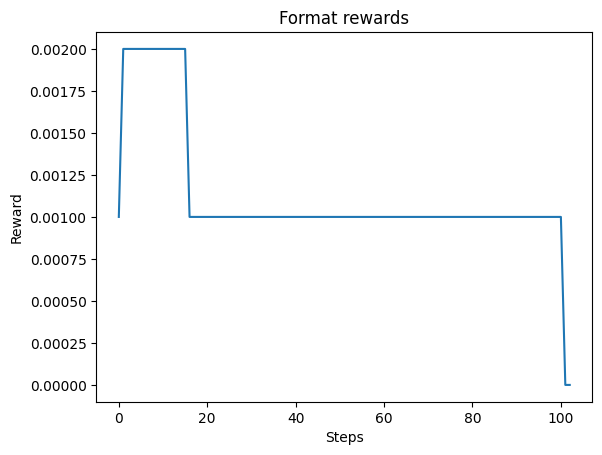

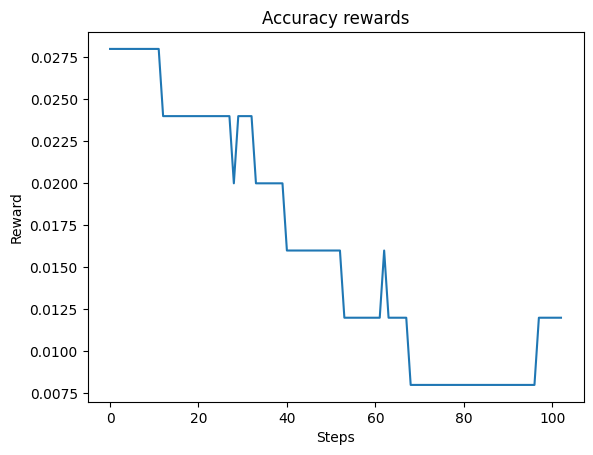

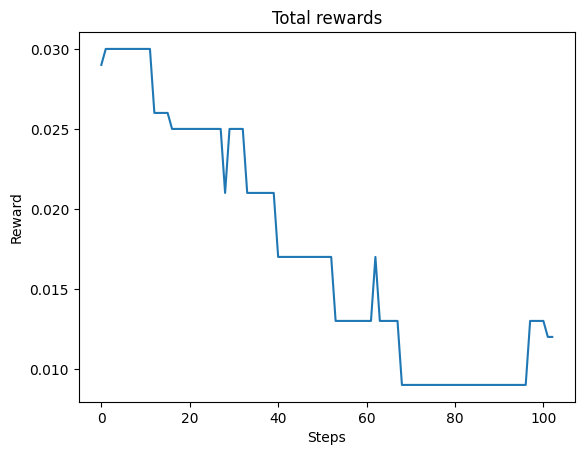

In [27]:
plt.plot(moving_average(track_format_rewards, window_size=100))
plt.title("Format rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(track_accuracy_rewards, window_size=100))
plt.title("Accuracy rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

###########
plt.plot(moving_average(total_rewards, window_size=100))
plt.title("Total rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()